In [ ]:
## IEX EDA starts here

In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(os.environ.get('IEX_SANDBOX_TOKEN'))
print(os.environ.get('IEX_TOKEN'))

Tsk_2f36139a7da4433bbc4882148386ff32
sk_adc1a33884d64226b0ad7b2e4a5f213e


In [51]:
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}


In [52]:
endpoint = '/stock/aapl/chart/3m'
# endpoint = '/stock/aapl/balance-sheet'
# endpoint = '/stock/aapl/financials'
# endpoint = '/time-series/reported_financials/AAPL/10-Q?last=2'
# endpoint = '/time-series'
# endpoint = '/stock/aapl/financials?period=quarter'

# endpoint = '/stock/aapl/price'
# endpoint = '/stock/aapl/income/10-Q?last=2'
# resp = requests.get(base_url+endpoint, params = params)
resp = requests.get(sandbox_url+endpoint, params = sandbox_params)
resp.raise_for_status()
resp = resp.json()

In [58]:
# resp

In [16]:
# If you plan to use this same endpoint a few times, it makes sense to create a function to avoid repeating code. Here is an example:

In [7]:
    
def revenue_history(_symbol, _url='sandbox', _last=12):
    
    # define parameters
    base_url = 'https://cloud.iexapis.com/v1'
    sandbox_url = 'https://sandbox.iexapis.com/stable'

    base_token = os.environ.get('IEX_TOKEN')
    sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
    base_params = {'token': base_token}
    sandbox_params = {'token': sandbox_token}
    
    ticker = f'{_symbol}'.lower() #IEX only accepts lower case ticker
    
    # _last defaul is 12; min is 1 (quarters)
    if _url == 'sandbox':
        endpoint = f'{sandbox_url}/stock/{ticker}/income/10-Q/?last={_last}'
        resp = requests.get(endpoint, params=sandbox_params)
    else:
        endpoint = f'{base_url}/stock/{ticker}/income/10-Q/?last={_last}'
        resp = requests.get(endpoint, params=base_params) # need IEX subscription in order to support this url
    resp.raise_for_status()
    resp = resp.json()
    
    
    rev = []
    rev_qrt = {}
    
    # extract date / quarter_number / quarterly_revenue
    for num in range(0,len(resp['income'])):
        for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
            rev_qrt[key] = resp['income'][num].setdefault(key)
        rev.append(rev_qrt)
        rev_qrt = {}
    
    # add TTM_Revenue
    # the last 3 TTM Revenue would not be available
    for i in range(0,len(rev)):
        if (i+3) < len(rev):
            rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']
   
    # Calculate YoY quarterly & yearly revenue growth rate
    q=0
    y=0
    while q < 8: # YOY quarterly growth is calculated every 4 quarters, so 12 quarters of data can only derive 8 data points
        rev[q]['Quarterly_Revenue_Growth'] = round((rev[q]['totalRevenue']/rev[q+4]['totalRevenue']-1)*100,2)
        q += 1
    while y < 5: # YOY same period growth is calculated every 4 data points, so 12 quarters of data can only derive 5 data points   
        rev[y]['TTM_Revenue_Growth'] = round((rev[y]['TTM_Revenue']/rev[y+4]['TTM_Revenue']-1)*100,2)
        y += 1
    
    # Convert to pandas DF
    rev_df = pd.DataFrame(rev)  
    # rename totalRevenue to Quarterly_Revenue
    rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
    
    # remove df rows where quarterly_revenue_growth is NaN
    rev_df = rev_df.loc[0:7]
    # use datetime format and sort df by date
    rev_df['fiscalDate'] = pd.to_datetime(rev_df['fiscalDate'], format='%Y/%m/%d')
    rev_df = rev_df.sort_values('fiscalDate')
    # transform date to year-month format
    rev_df["date_yrmo"] = rev_df['fiscalDate'].dt.strftime('%Y-%m')
    
    # calculate monthly average stock price 
    if _url == 'sandbox':
        endpoint = f'{sandbox_url}/stock/{ticker}/chart/39m'
        resp = requests.get(endpoint, params=sandbox_params)
    else:
        endpoint = f'{base_url}/stock/{ticker}/chart/39m'
        resp = requests.get(endpoint, params=base_params) # need IEX subscription in order to support this url
    
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())
    df = df[["symbol","date","fClose","fVolume"]]
    # transform date to year-month format
    df["date"] = pd.to_datetime(df['date'], format='%Y/%m/%d')
    df["date_yrmo"] = df['date'].dt.strftime('%Y-%m')
    # average close price by month
    df1 = df.groupby('date_yrmo')['fClose'].mean().reset_index(name='avg_monthly_price')
    df1['avg_monthly_price'] = round(df1['avg_monthly_price'],2)
    df = pd.merge(df, df1, on='date_yrmo', how='left')
    # average volume by month
#     df2 = df.groupby('date_yrmo')['fVolume'].mean().reset_index(name='avg_monthly_volume')
#     df = pd.merge(df, df2, on='date_yrmo', how='left')
    # merge df
    rev_df = pd.merge(rev_df, df, on='date_yrmo', how='left')
    
    
    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Plotting
    fig = plt.figure(figsize=(16,9), dpi=100)
    ax = fig.add_subplot(111)

    ln1 = ax.plot(rev_df.date_yrmo, rev_df.Quarterly_Revenue_Growth, '-', label = 'Quarterly Revenue Growth Rate', color='tab:blue', linewidth=8)
    ln2 = ax.plot(rev_df.date_yrmo, rev_df.TTM_Revenue_Growth, '-', label = 'TTM Revenue Growth Rate', color='tab:green', linewidth=8)
    ax2 = ax.twinx()
    ln3 = ax2.plot(rev_df.date_yrmo, rev_df.avg_monthly_price, 'r', label = 'Monthly Avg Stock Price', color='tab:red', linewidth=3)

    # combine three lines
    ln = ln1+ln2+ln3
    labs = [l.get_label() for l in ln]

    ax.legend(ln, labs, loc='upper right')#, ncol=3, mode = "expand")
    company = f'{_symbol}'.upper() # make stock symbol upper case
    ax.set_title(f'{company}: YoY Quarterly vs TTM Revenue Growth Rate and Stock Price', fontsize=16)
    ax.grid(alpha=.2)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_ylabel('Revenue Growth Rate (%)', fontsize=16)
    ax2.set_ylabel('Monthly Average Stock Price ($)', fontsize=16)
    fig.tight_layout()
    plt.show()
    #----------------------------------------------------------------------------------------------------------------------------------------------
   
#     return rev_df
    return None
    

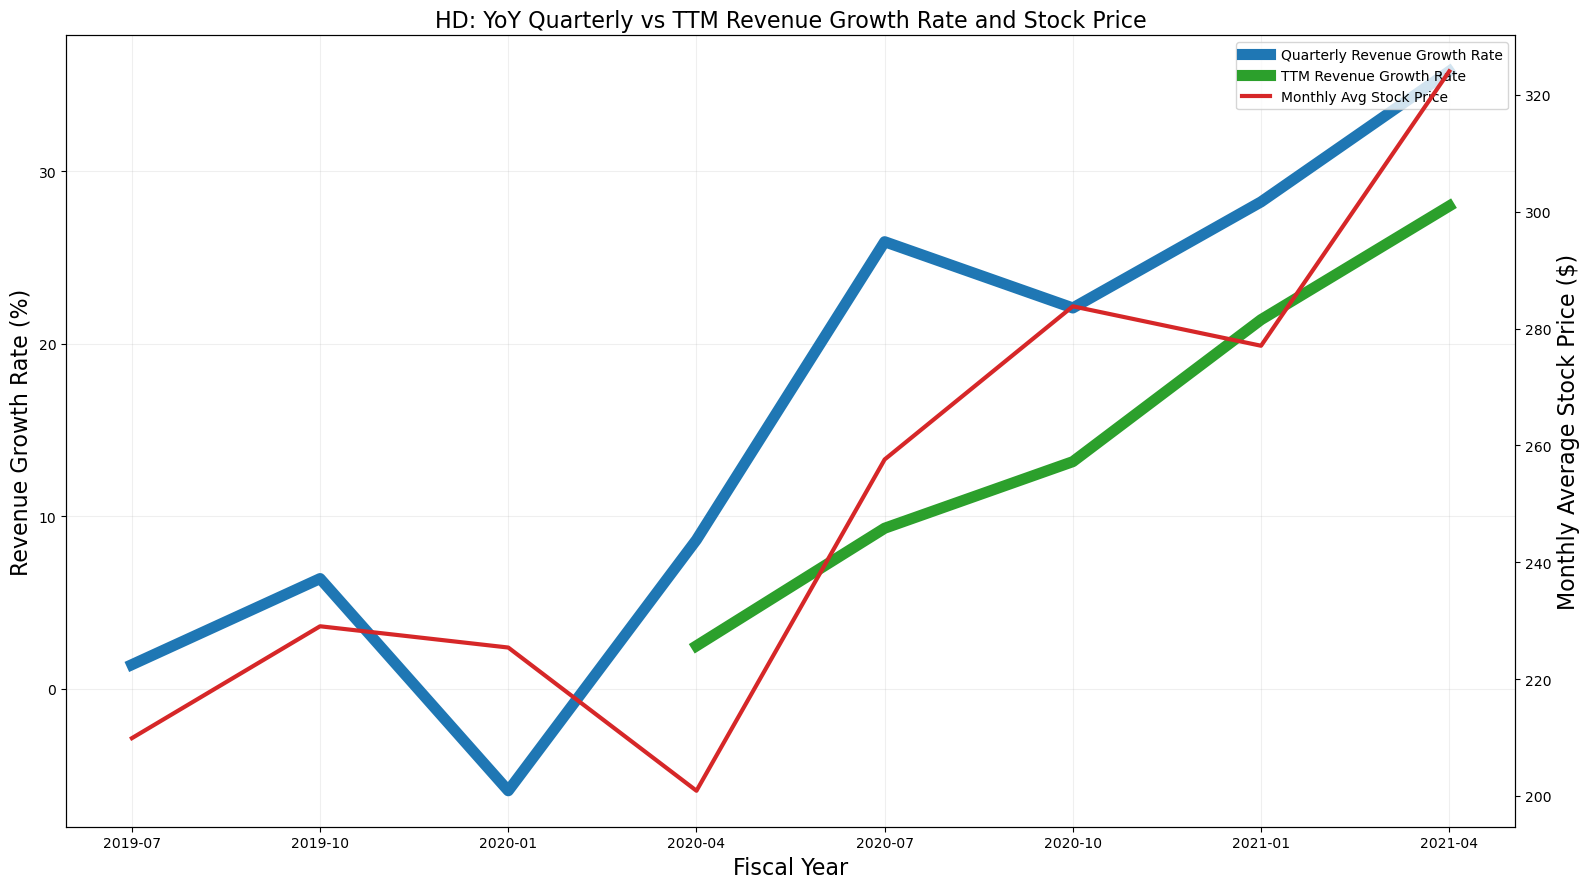

,fiscalDate,fiscalQuarter,Quarterly_Revenue,TTM_Revenue,Quarterly_Revenue_Growth,TTM_Revenue_Growth,date_yrmo,symbol,date,fClose,fVolume,avg_monthly_price
0,2019-07-20,2,31029472144,1.115955e+11,1.4,NaN,2019-07,HD,2019-07-01,203.8744,4156764,209.89
1,2019-07-20,2,31029472144,1.115955e+11,1.4,NaN,2019-07,HD,2019-07-02,208.5000,3255347,209.89
2,2019-07-20,2,31029472144,1.115955e+11,1.4,NaN,2019-07,HD,2019-07-03,211.7766,2274569,209.89
3,2019-07-20,2,31029472144,1.115955e+11,1.4,NaN,2019-07,HD,2019-07-05,206.9590,2586535,209.89
4,2019-07-20,2,31029472144,1.115955e+11,1.4,NaN,2019-07,HD,2019-07-08,204.3230,2812459,209.89
...,...,...,...,...,...,...,...,...,...,...,...,...
166,2021-04-17,1,38977784079,1.458244e+11,35.8,27.99,2021-04,HD,2021-04-26,327.5686,2920202,324.02
167,2021-04-17,1,38977784079,1.458244e+11,35.8,27.99,2021-04,HD,2021-04-27,324.2726,3445081,324.02
168,2021-04-17,1,38977784079,1.458244e+11,35.8,27.99,2021-04,HD,2021-04-28,319.5758,2760750,324.02
169,2021-04-17,1,38977784079,1.458244e+11,35.8,27.99,2021-04,HD,2021-04-29,328.1291,3413569,324.02


In [6]:
appl_rev_trend = revenue_history('HD', 'sandbox', 12)
appl_rev_trend
